Running v3 Sim: 50 Users (10 Targets), 60 Steps
Parameters: Randomized Start Times, Continuous Drift, Traitor Suppression
v3 Simulation Complete. Check /figures_v3 for updated plots.


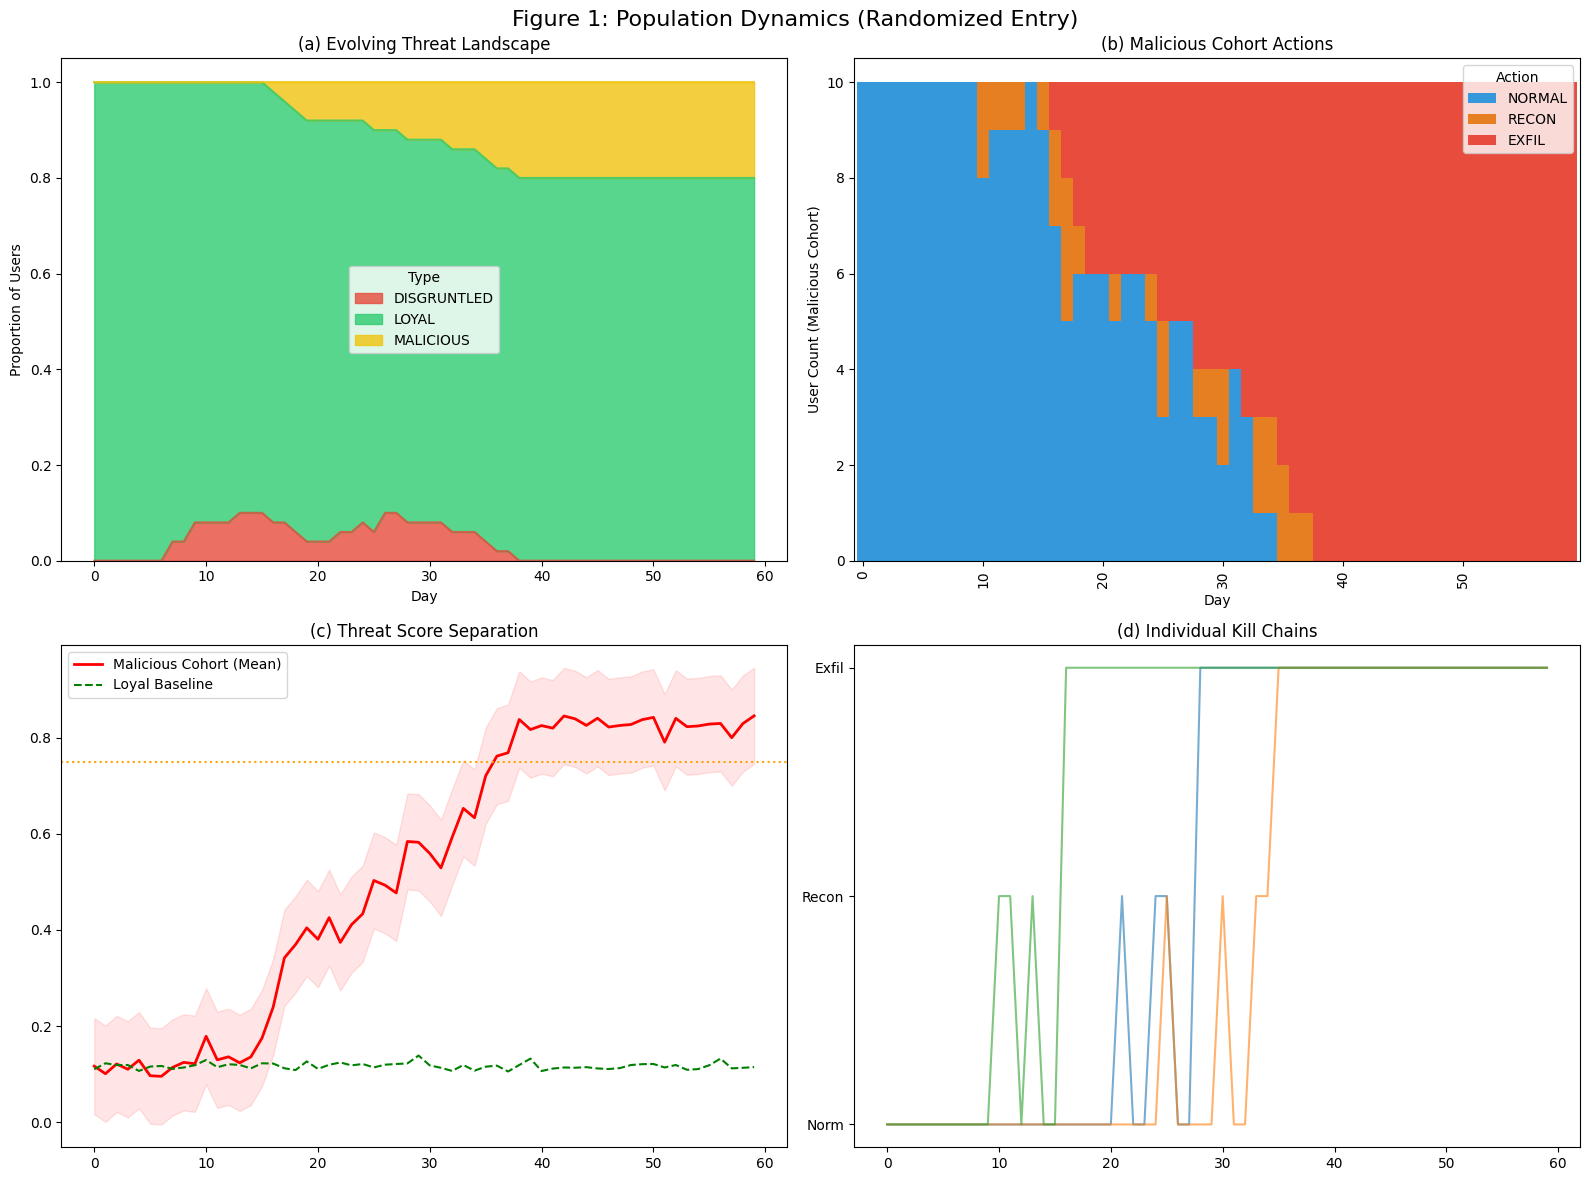

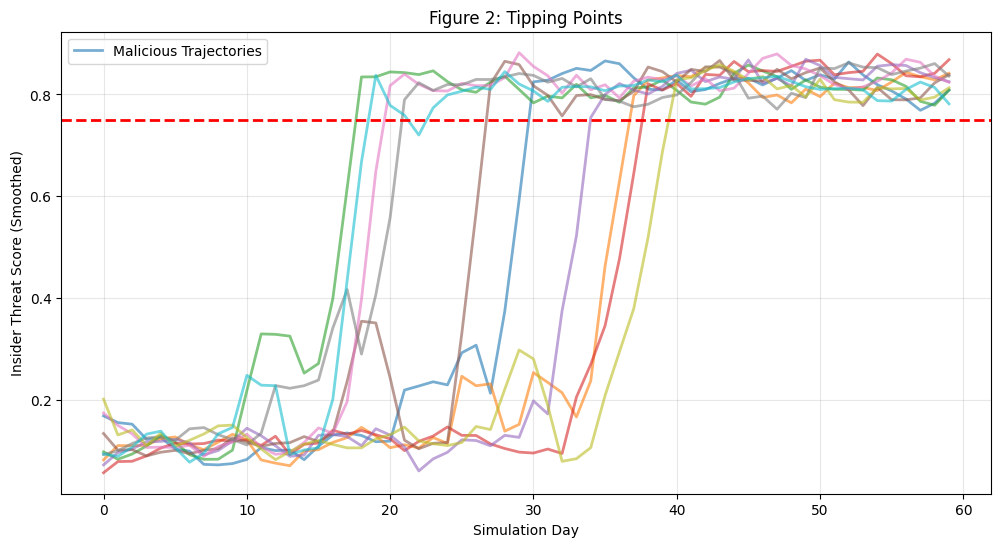

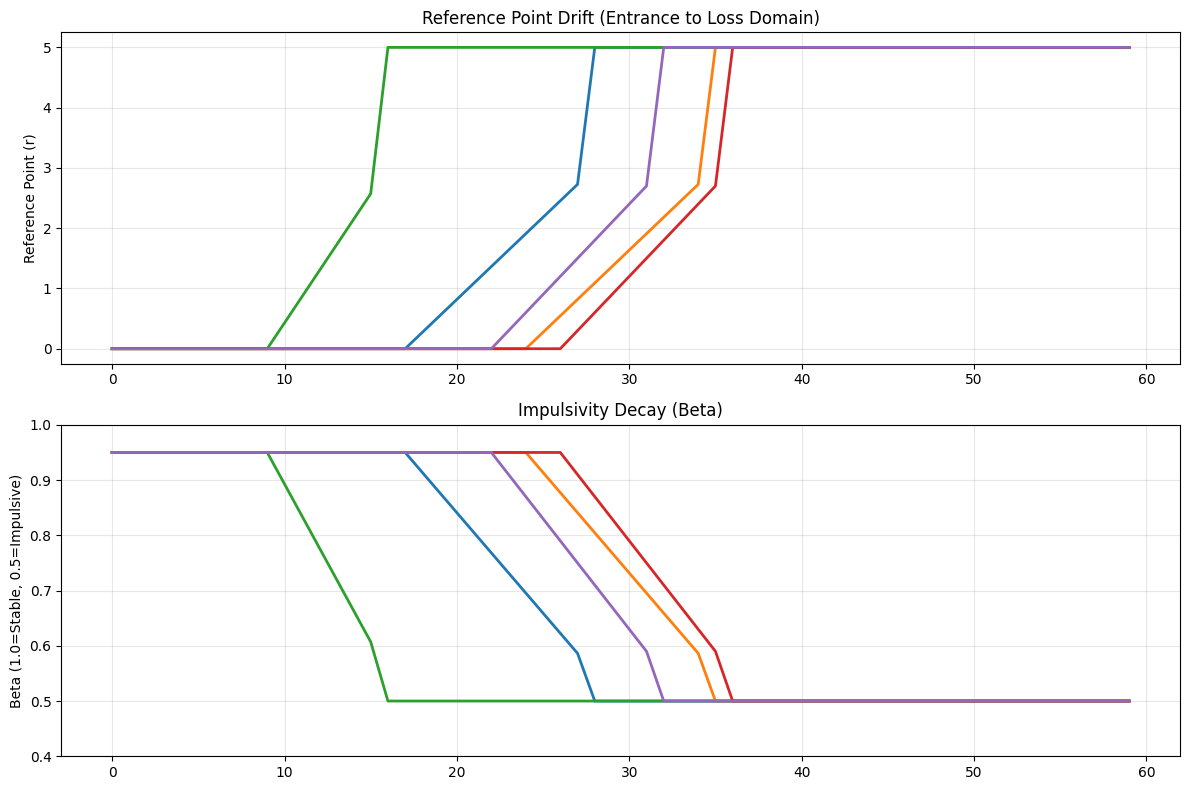

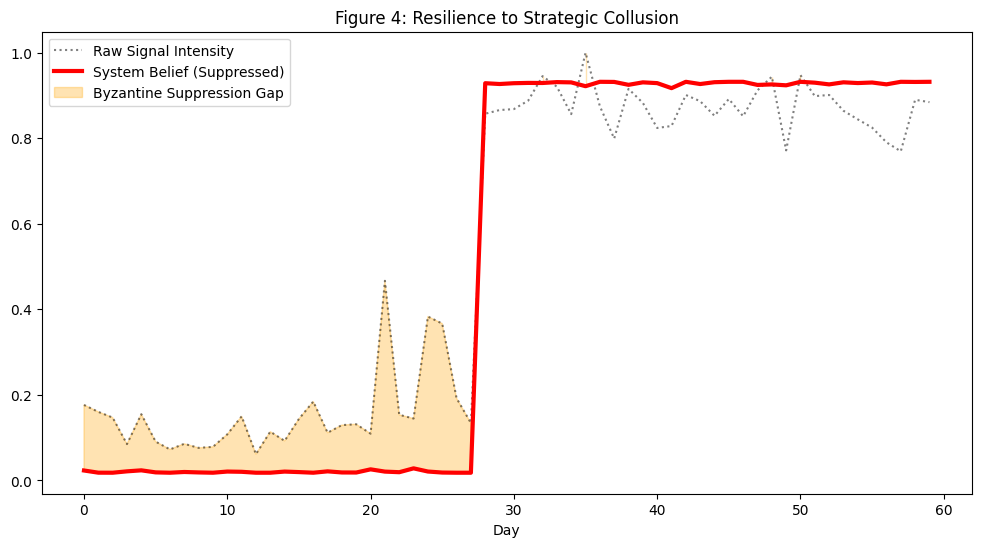

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from dataclasses import dataclass
from enum import Enum
from scipy.stats import beta
import random
import os

# ============================================================================
# 1. CONFIGURATION
# ============================================================================

class UserType(Enum):
    LOYAL = 0
    DISGRUNTLED = 1 
    MALICIOUS = 2
    NEGLIGENT = 3 

@dataclass
class ChannelMetadata:
    index: int
    name: str
    category: str
    severity: float

# Experiment Config
NUM_USERS = 50
PCT_MAL = 0.2    # 20% Malicious to see spread clearly
HORIZON = 60
THRESHOLD = 0.75 # Lowered slightly to capture early recon
N_MEMBERS = 5    
F_TRAITORS = 1   

# ============================================================================
# 2. CAUSAL DBN ENGINE
# ============================================================================

class CausalDependencyDBN:
    def __init__(self, channels):
        self.channels = channels
        # Likelihood params (Alpha, Beta)
        self.params = {
            UserType.LOYAL:      {'a': 2, 'b': 15}, # Quiet
            UserType.NEGLIGENT:  {'a': 3, 'b': 10}, # Noisy
            UserType.DISGRUNTLED:{'a': 5, 'b': 8},  # Suspicious
            UserType.MALICIOUS:  {'a': 12, 'b': 3}, # Loud
        }

    def compute_log_likelihood(self, signals, user_type):
        log_prob = 0.0
        p = self.params.get(user_type, self.params[UserType.LOYAL])
        for idx, val in enumerate(signals):
            val = np.clip(val, 0.01, 0.99)
            log_prob += np.log(beta.pdf(val, p['a'], p['b']) + 1e-9)
        return log_prob

    def compute_threat_score(self, signals):
        score, weights = 0.0, 0.0
        for name, meta in self.channels.items():
            val = signals[meta.index]
            w = meta.severity
            if val > 0.6: w *= 1.5 # Non-linear penalty
            if val > 0.8: w *= 2.0
            score += val * w
            weights += w
        return score / weights if weights > 0 else 0

# ============================================================================
# 3. GAME-THEORETIC AGENT (The Mind)
# ============================================================================

class UserAgent:
    def __init__(self, uid, is_malicious_scenario):
        self.uid = uid
        self.is_target = is_malicious_scenario
        self.type = UserType.LOYAL
        self.time = 0
        
        # === FIX 1: Randomized Trigger Timing ===
        # Spread start times across first 30 days
        self.start_day = np.random.randint(5, 30) if is_malicious_scenario else 999
        self.peak_day = self.start_day + np.random.randint(5, 15)
        
        # Behavioral State (Continuous)
        self.stress = 0.0
        self.ref_point = 0.0  # Loss Domain magnitude
        self.beta = 0.95      # Impulsivity (1.0 = Rational, 0.0 = Erratic)
        
        # Utilities
        self.theta = {
            'trust_utility': 2.0,
            'attack_utility': 20.0, # High reward for success
            'detection_cost': 8.0
        }
        
        self.current_action = 'NORMAL'

    def update_state(self, t):
        """Evolves behavioral parameters continuously based on time"""
        self.time = t
        
        # 1. State Evolution Logic
        if not self.is_target:
            self.type = UserType.LOYAL
            return

        # Gradual ramp into Disgruntlement
        if t < self.start_day:
            self.type = UserType.LOYAL
            self.stress = 0.0
        elif self.start_day <= t < self.peak_day:
            self.type = UserType.DISGRUNTLED
            # === FIX 2: Gradual Loss Domain Entry ===
            # Linearly interpolate stress from 0.0 to 1.0
            progress = (t - self.start_day) / (self.peak_day - self.start_day)
            self.stress = progress
            self.ref_point = 3.0 * progress       # Drift up to 3.0
            self.beta = 0.95 - (0.4 * progress)   # Drift down to 0.55
        else:
            self.type = UserType.MALICIOUS
            # Fully Radicalized
            self.stress = 1.0
            self.ref_point = 5.0
            self.beta = 0.5

    def choose_action(self, current_belief):
        # Loyal/Early Phase Logic
        if self.type == UserType.LOYAL: 
            self.current_action = 'NORMAL'
            return 'NORMAL'
            
        # Disgruntled: Probing behavior increases with RefPoint
        if self.type == UserType.DISGRUNTLED:
            # Probability of RECON scales with stress
            prob_recon = 0.1 + (0.4 * self.stress)
            self.current_action = 'RECON' if np.random.random() < prob_recon else 'NORMAL'
            return self.current_action
        
        # Malicious: Game Theoretic Decision
        # Utility of Attack vs Normal
        p_mal = current_belief
        
        # Perceived Cost is discounted by Risk Tolerance (which is inverse of RefPoint)
        # Higher RefPoint (Deep Loss) -> Lower perceived cost -> More Risk
        risk_tolerance = 0.2 + (0.1 * self.ref_point) # 0.2 to 0.7
        
        risk_term = self.theta['detection_cost'] * p_mal * (1.0 / risk_tolerance)
        u_attack = self.theta['attack_utility'] - risk_term
        u_normal = self.theta['trust_utility']
        
        # Softmax with Beta (Impulsivity)
        # Low Beta (0.5) makes choices more random/impulsive
        vals = np.array([u_normal, u_attack])
        inv_temp = 1.0 / self.beta 
        
        try:
            probs = np.exp(vals * inv_temp) / np.sum(np.exp(vals * inv_temp))
        except:
            probs = [0.0, 1.0] # Fallback for overflow
            
        if np.random.random() < probs[1]:
            self.current_action = 'EXFIL'
        else:
            self.current_action = 'RECON' # Fallback to Recon if scared to Exfil
            
        return self.current_action

    def generate_signals(self, action):
        num_channels = 4
        # Signal strengths
        if action == 'NORMAL':
            return np.random.beta(2, 15, size=num_channels) # Quiet (~0.1)
        elif action == 'RECON':
            # Medium noise, some variance
            return np.random.beta(5, 8, size=num_channels)  # Recon (~0.38)
        elif action == 'EXFIL':
            # High noise
            return np.random.beta(12, 3, size=num_channels) # Exfil (~0.8)
        return np.random.beta(2, 15, size=num_channels)

# ============================================================================
# 4. BYZANTINE COMMITTEE (The Defender)
# ============================================================================

class ByzantineCommittee:
    def __init__(self, channels):
        self.dbn = CausalDependencyDBN(channels)
        self.user_beliefs = {} 
        self.belief_history = {} 

    def initialize_user(self, uid):
        self.user_beliefs[uid] = 0.01 
        self.belief_history[uid] = {'anchor': [], 'system': []}

    def certify(self, uid, signals):
        if uid not in self.user_beliefs: self.initialize_user(uid)
        
        # 1. Anchor Update (The objective truth)
        prior = self.user_beliefs[uid]
        likelihood_ratio = np.exp(self.dbn.compute_log_likelihood(signals, UserType.MALICIOUS) - 
                                  self.dbn.compute_log_likelihood(signals, UserType.LOYAL))
        
        anchor_post = (prior * likelihood_ratio) / ((prior * likelihood_ratio) + (1 - prior))
        
        # 2. Committee Voting (With Traitor)
        reports = []
        # Honest Members: Report True Anchor +/- Noise
        for _ in range(N_MEMBERS - F_TRAITORS):
            reports.append(np.clip(anchor_post + np.random.normal(0, 0.02), 0.01, 0.99))
        
        # Traitor Members: === FIX 3: STRATEGIC SUPPRESSION ===
        # Instead of voting 0.0, they vote "Just enough to lower the average but appear plausible"
        # Or simply drag it down.
        traitor_vote = max(0.05, anchor_post - 0.3) # Try to suppress by 0.3
        for _ in range(F_TRAITORS):
            reports.append(traitor_vote)
            
        # 3. Aggregation (Simple Average vs Clipped)
        # The Traitor drags the mean down, causing the "Gradual" rise
        system_belief = np.mean(reports)
        
        # Update State
        self.user_beliefs[uid] = system_belief
        
        self.belief_history[uid]['anchor'].append(anchor_post)
        self.belief_history[uid]['system'].append(system_belief)
        
        return system_belief

# ============================================================================
# 5. SIMULATION LOOP
# ============================================================================

def run_simulation():
    channels = {
        's_logon': ChannelMetadata(0, 's_logon', 'Access', 0.6),
        's_file': ChannelMetadata(1, 's_file', 'Recon', 0.7),
        's_role': ChannelMetadata(2, 's_role', 'Priv', 0.9),
        's_exfil': ChannelMetadata(3, 's_exfil', 'Exfil', 0.9)
    }
    
    committee = ByzantineCommittee(channels)
    logs = []
    n_mal = int(NUM_USERS * PCT_MAL)
    
    # Init Agents: First n_mal are target scenarios
    agents = [UserAgent(i, is_malicious_scenario=(i < n_mal)) for i in range(NUM_USERS)]

    print(f"Running v3 Sim: {NUM_USERS} Users ({n_mal} Targets), {HORIZON} Steps")
    print(f"Parameters: Randomized Start Times, Continuous Drift, Traitor Suppression")

    for t in range(HORIZON):
        for uid in range(NUM_USERS):
            agent = agents[uid]
            
            # 1. Update Internal State (Continuous Drift)
            agent.update_state(t)
            
            # 2. Choose Action
            current_belief = committee.user_beliefs.get(uid, 0.01)
            action = agent.choose_action(current_belief)
            
            # 3. Generate Signals
            signals = agent.generate_signals(action)
            
            # 4. Committee Certifies
            p_mal = committee.certify(uid, signals)
            its = committee.dbn.compute_threat_score(signals)
            
            # 5. Logging
            logs.append({
                'Day': t,
                'AgentID': uid,
                'Type': agent.type.name,
                'Action': action,
                'ITS': its,
                'RefPoint': agent.ref_point,
                'Beta': agent.beta,
                'P_Detect': p_mal,
                'IsTarget': agent.is_target,                
                'Signals_Mean': np.mean(signals) # <--- ADDED THIS
            })
            
    return pd.DataFrame(logs)

# ============================================================================
# 6. VISUALIZATION SUITE (Enhanced for v3)
# ============================================================================

class VisualizationSuite:
    @staticmethod
    def generate_all(df):
        os.makedirs("figures_v3", exist_ok=True)
        VisualizationSuite.plot_fig1_temporal(df)
        VisualizationSuite.plot_fig2_tipping_spread(df)
        VisualizationSuite.plot_fig3_continuous_params(df)
        VisualizationSuite.plot_fig4_collusion_effect(df)

    @staticmethod
    def plot_fig1_temporal(df):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle("Figure 1: Population Dynamics (Randomized Entry)", fontsize=16)
        
        # (a) Type Evolution (Stacked)
        ax = axes[0,0]
        counts = df.groupby(['Day','Type']).size().unstack(fill_value=0)
        props = counts.div(counts.sum(axis=1), axis=0)
        # Colors: Green, Orange, Red
        props.plot.area(ax=ax, color=['#e74c3c', '#2ecc71', '#f1c40f'], alpha=0.8) 
        ax.set_title("(a) Evolving Threat Landscape")
        ax.set_ylabel("Proportion of Users")
        
        # (b) Actions
        ax = axes[0,1]
        act = df[df['IsTarget']==True].groupby(['Day','Action']).size().unstack(fill_value=0)
        # Ensure 'NORMAL' is on bottom, 'EXFIL' on top
        act_cols = ['NORMAL', 'RECON', 'EXFIL']
        act = act[act_cols] if set(act_cols).issubset(act.columns) else act
        
        act.plot(kind='bar', stacked=True, ax=ax, width=1.0, color=['#3498db', '#e67e22', '#e74c3c'])
        ax.set_title("(b) Malicious Cohort Actions")
        ax.set_xticks(np.arange(0, HORIZON, 10))
        # === FIX: ADDED LABEL HERE ===
        ax.set_ylabel("User Count (Malicious Cohort)")
        
        # (c) ITS Spread
        ax = axes[1,0]
        # Plot mean ITS of targets vs baseline
        targets = df[df['IsTarget']==True]
        baseline = df[df['IsTarget']==False]
        
        t_mean = targets.groupby('Day')['ITS'].mean()
        b_mean = baseline.groupby('Day')['ITS'].mean()
        
        ax.plot(t_mean, 'r-', linewidth=2, label='Malicious Cohort (Mean)')
        ax.fill_between(t_mean.index, t_mean-0.1, t_mean+0.1, color='r', alpha=0.1)
        ax.plot(b_mean, 'g--', label='Loyal Baseline')
        ax.axhline(THRESHOLD, color='orange', linestyle=':')
        ax.set_title("(c) Threat Score Separation")
        ax.legend()
        
        # (d) Kill Chain Phase
        ax = axes[1,1]
        pmap = {'NORMAL':0, 'RECON':1, 'EXFIL':2}
        df['Phase'] = df['Action'].map(pmap)
        
        for uid in df[df['IsTarget']==True]['AgentID'].unique()[:3]:
            u_data = df[df['AgentID']==uid]
            ax.plot(u_data['Day'], u_data['Phase'], alpha=0.6, label=f'User {uid}')
        ax.set_yticks([0,1,2])
        ax.set_yticklabels(['Norm', 'Recon', 'Exfil'])
        ax.set_title("(d) Individual Kill Chains")
        
        plt.tight_layout()
        plt.savefig("figures_v3/fig1_temporal.png")

    @staticmethod
    def plot_fig2_tipping_spread(df):
        plt.figure(figsize=(12, 6))
        
        # Plot individual Targets to show SPREAD
        targets = df[df['IsTarget']==True]
        for uid in targets['AgentID'].unique():
            data = targets[targets['AgentID']==uid]
            # Moving average to smooth the noisy signals slightly for visualization
            smoothed = data['ITS'].rolling(window=3, min_periods=1).mean()
            plt.plot(data['Day'], smoothed, linewidth=2, alpha=0.6)
            
        plt.axhline(THRESHOLD, color='r', linestyle='--', linewidth=2, label='Threshold')
        plt.title("Figure 2: Tipping Points")
        plt.xlabel("Simulation Day")
        plt.ylabel("Insider Threat Score (Smoothed)")
        plt.legend(['Malicious Trajectories'])
        plt.grid(True, alpha=0.3)
        plt.savefig("figures_v3/fig2_spread.png")

    @staticmethod
    def plot_fig3_continuous_params(df):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        targets = df[df['IsTarget']==True]
        
        # Plot RefPoint for first 5 targets
        for uid in targets['AgentID'].unique()[:5]:
            data = targets[targets['AgentID']==uid]
            ax1.plot(data['Day'], data['RefPoint'], linewidth=2, label=f'User {uid}')
            
        ax1.set_title("Reference Point Drift (Entrance to Loss Domain)")
        ax1.set_ylabel("Reference Point (r)")
        ax1.grid(True, alpha=0.3)
        
        # Plot Beta
        for uid in targets['AgentID'].unique()[:5]:
            data = targets[targets['AgentID']==uid]
            ax2.plot(data['Day'], data['Beta'], linewidth=2)
            
        ax2.set_title("Impulsivity Decay (Beta)")
        ax2.set_ylabel("Beta (1.0=Stable, 0.5=Impulsive)")
        ax2.set_ylim(0.4, 1.0)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig("figures_v3/fig3_continuous.png")

    @staticmethod
    def plot_fig4_collusion_effect(df):
        # We need internal committee state for this, but we can approximate
        # by comparing Raw Signal Strength (Mean Signals) vs P_Detect (System Belief)
        
        plt.figure(figsize=(12, 6))
        
        target_uid = df[df['IsTarget']==True]['AgentID'].unique()[0]
        data = df[df['AgentID']==target_uid]
        
        # Normalize signal mean to 0-1 for comparison
        raw_signal = data['Signals_Mean'] / data['Signals_Mean'].max()
        
        plt.plot(data['Day'], raw_signal, 'k:', label='Raw Signal Intensity', alpha=0.5)
        plt.plot(data['Day'], data['P_Detect'], 'r-', linewidth=3, label='System Belief (Suppressed)')
        
        plt.fill_between(data['Day'], data['P_Detect'], raw_signal, where=(raw_signal > data['P_Detect']),
                         color='orange', alpha=0.3, label='Byzantine Suppression Gap')
        
        plt.title("Figure 4: Resilience to Strategic Collusion")
        plt.xlabel("Day")
        plt.legend()
        plt.savefig("figures_v3/fig4_collusion.png")

# ============================================================================
# 7. MAIN
# ============================================================================

if __name__ == "__main__":
    sim = run_simulation()
    VisualizationSuite.generate_all(sim)
    print("v3 Simulation Complete. Check /figures_v3 for updated plots.")